In [309]:
import pandas as pd
import os
import requests
import numpy as np

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [311]:
from preprocessing_utils import preprocess_NVD_data

In [312]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

In [313]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


In [314]:
epss_old = pd.read_csv(os.path.join(
    data_path, 'epss_scores-2025-09-30.csv.gz'), compression='gzip', header=1)


# NVD data
Query the official API of the National Vulnerability Database (NVD) to collect all vulnerabilities published between September 1 and October 1, 2025.
The goal is to retrieve all CVEs (Common Vulnerabilities and Exposures) published in a given time interval, managing the pagination of the results.

In [315]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


pd.json_normalize(...): converte la lista di dizionari JSON (all_cves) in un DataFrame tabellare, appiattendo le strutture annidate
preprocess_NVD_data(...):
    - Convert date fields
    - Extract English description, CVSS data, vulnerable CPEs, CWEs, number of references
    - Drop raw columns that are no longer needed

df.merge():
Unisce i dati NVD con quelli EPSS:
- left_on="cve.id": chiave CVE nel DataFrame NVD
- right_on="cve": chiave CVE nel DataFrame EPSS (epss_current)
- how="left": mantiene tutte le righe NVD, aggiungendo EPSS dove disponibile
EPSS fornisce una probabilità che una vulnerabilità venga sfruttata, utile per prioritizzare i rischi.

In [316]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus'] != 'Reserved') & (df['cve.vulnStatus'] != 'Reject')]

epss_current = epss_current.rename(columns={
    "epss": "epss_current",
    "percentile": "percentile_current"
})
epss_old = epss_old.rename(columns={
    "epss": "epss_old",
    "percentile": "percentile_old"
})


# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")
df = df.merge(epss_old, left_on='cve.id', right_on='cve', how='left')


In [317]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_10.csv"))

# Exploratory Data Analysis

In [318]:
print(df.columns)


Index(['cve.id', 'cve.sourceIdentifier', 'cve.published', 'cve.lastModified',
       'cve.vulnStatus', 'cve.references', 'cve.cisaExploitAdd',
       'cve.cisaActionDue', 'cve.cisaRequiredAction',
       'cve.cisaVulnerabilityName', 'description', 'vulnerable_cpes',
       'num_references', 'cwe_list', 'cvss_version', 'cvss_vectorString',
       'cvss_baseScore', 'cvss_baseSeverity', 'cvss_attackVector',
       'cvss_attackComplexity', 'cvss_privilegesRequired',
       'cvss_userInteraction', 'cvss_scope', 'cvss_confidentialityImpact',
       'cvss_integrityImpact', 'cvss_availabilityImpact', 'cve_x',
       'epss_current', 'percentile_current', 'cve_y', 'epss_old',
       'percentile_old'],
      dtype='object')


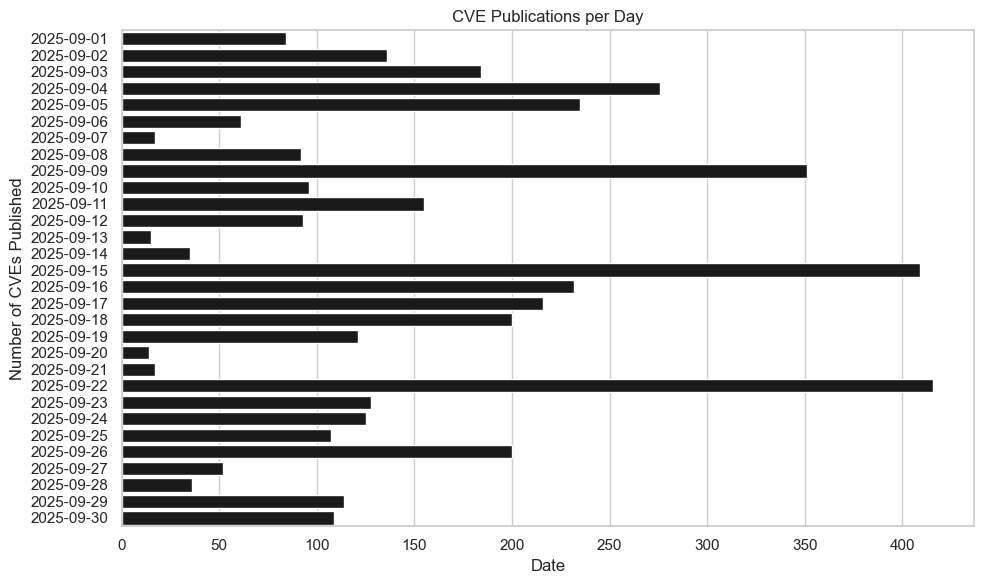

In [319]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=published_counts.values, y=published_counts.index, color="k")
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()


- display some examples (e.g., the first two CVE records)

In [320]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- show a bar plot with the daily volume of published CVEs

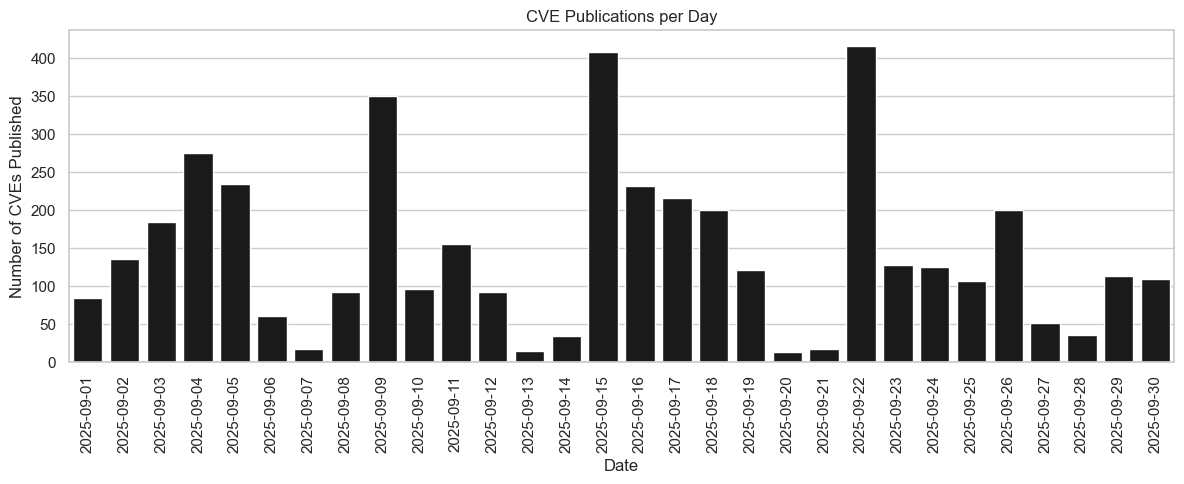

In [321]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

- print the description of the last ten published vulnerabilities

df.iterrows() restituisce un generatore che produce:  
    - idx: l’indice della riga (può essere numerico o un valore personalizzato)  
    - x: la riga stessa, rappresentata come una Serie Pandas

In [322]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### What is the percentage of CVEs which received a CVSS score?

In [323]:
total_cves = len(df)
scored_cves = df["cvss_baseScore"].notna().sum()
percentage = (scored_cves / total_cves) * 100
print(f"Percentage of CVEs with CVSS score: {percentage:.2f}%")

Percentage of CVEs with CVSS score: 77.18%


### Report descriptive statistics of CVSS the CVSS base score and/or show its distribution
The CVSS base scores range from 0 to 10, with a mean value of 6.47 and a standard deviation of 2.11.
The distribution is slightly skewed towards higher values, indicating that most vulnerabilities are classified as High or Critical severity

In [324]:
# Considera solo i valori numerici di CVSS
scores = df["cvss_baseScore"].dropna().astype(float)
stats = scores.describe()
print(stats)

count    3339.000000
mean        6.899611
std         1.805788
min         1.900000
25%         5.400000
50%         6.500000
75%         8.100000
max        10.000000
Name: cvss_baseScore, dtype: float64


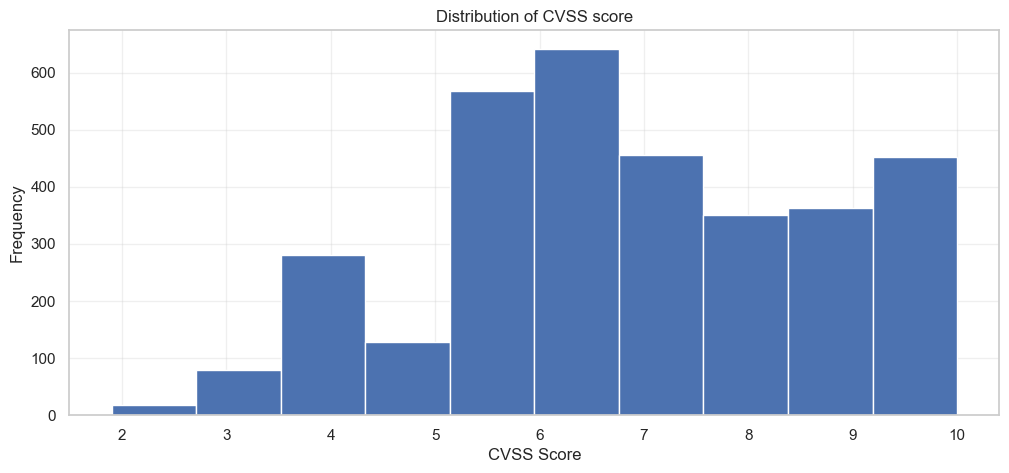

In [325]:
cvsss = df[df["cvss_baseScore"].notna()]
plt.figure(figsize=(12, 5))
plt.title("Distribution of CVSS score")
plt.hist(cvsss["cvss_baseScore"])
plt.ylabel("Frequency")
plt.xlabel("CVSS Score")
plt.grid(alpha=0.3)

plt.show()


### CVSS Severity Classification

The CVSS scores were classified into severity categories using the standard thresholds: **Low (<4.0)**, **Medium (4.0–6.9)**, **High (7.0–8.9)**, and **Critical (≥9.0)**.  

The distribution of vulnerabilities by severity is as follows:

- **Medium:** ~48.5% of vulnerabilities, representing the largest group.  
- **High:** ~33.2%, indicating a substantial portion of issues with significant impact.  
- **Critical:** ~14.8%, the most severe vulnerabilities, requiring immediate attention.  
- **Low:** ~3.6%, the least frequent, suggesting that minor vulnerabilities are rare in this dataset.  

Overall, the distribution is skewed towards **Medium and High severity**, highlighting that most vulnerabilities are of **moderate to high concern** and warrant careful management.


In [326]:
def classify_severity(score):
    if score < 4.0:
        return "Low"
    elif score < 7.0:
        return "Medium"
    elif score < 9.0:
        return "High"
    else:
        return "Critical"

df["severity"] = scores.apply(classify_severity)

print(df["severity"].value_counts(normalize=True) * 100)


severity
Medium      48.457622
High        33.153639
Critical    14.764900
Low          3.623839
Name: proportion, dtype: float64


### EPSS Descriptive Statistics

The Exploit Prediction Scoring System (EPSS) scores were analyzed considering only valid numeric values. The descriptive statistics of the EPSS distribution are as follows:

- **Count:** 4,326 valid observations were included in the analysis.  
- **Mean:** The average EPSS score is approximately **0.0021**, indicating that most vulnerabilities have a very low predicted likelihood of exploitation.  
- **Standard Deviation (std):** **0.0253**, suggesting that while most scores are low, there is some variability in the dataset.  
- **Minimum (min):** The lowest observed EPSS score is **0.00002**, close to zero.  
- **25th Percentile (Q1):** **0.00025**, meaning 25% of vulnerabilities have extremely low predicted exploitability.  
- **Median (50th Percentile):** **0.00035**, confirming that the central tendency is also very low.  
- **75th Percentile (Q3):** **0.00051**, indicating that even the upper quartile of vulnerabilities generally have low EPSS scores.  
- **Maximum (max):** **0.6877**, a clear outlier compared to the bulk of the data, suggesting a few vulnerabilities with a relatively high predicted likelihood of exploitation.

Overall, the EPSS distribution is **heavily skewed towards very low values**, with most vulnerabilities having minimal predicted exploitability, while a small number of vulnerabilities stand out with considerably higher risk.


In [327]:
# Considera solo i valori numerici validi di EPSS
epss = df["epss_current"].dropna().astype(float)

# Statistiche descrittive
stats = epss.describe()
print(stats)


count    4326.000000
mean        0.001476
std         0.017277
min         0.000020
25%         0.000240
50%         0.000320
75%         0.000470
max         0.810640
Name: epss_current, dtype: float64


### Distribution of EPSS Scores

The Exploit Prediction Scoring System (EPSS) scores were plotted to visualize their distribution.  

On a **linear scale**, the histogram shows that the vast majority of vulnerabilities have very low EPSS scores, concentrated between approximately 10<sup>-4</sup> and 10<sup>-3</sup>. As a result, most of the data appears compressed into a single high-frequency bar, making it difficult to discern the distribution of smaller values.  

To better visualize the distribution, a **logarithmic scale** was applied to the x-axis. This transformation spreads out the lower values and highlights differences among vulnerabilities with low predicted exploitability. The log-scale histogram reveals that while most vulnerabilities have minimal likelihood of exploitation, a few cases exhibit significantly higher EPSS scores, standing out as potential high-risk vulnerabilities.  

Overall, the EPSS distribution is **heavily skewed towards very low probabilities**, with a long tail of higher values representing a small number of vulnerabilities with elevated risk.


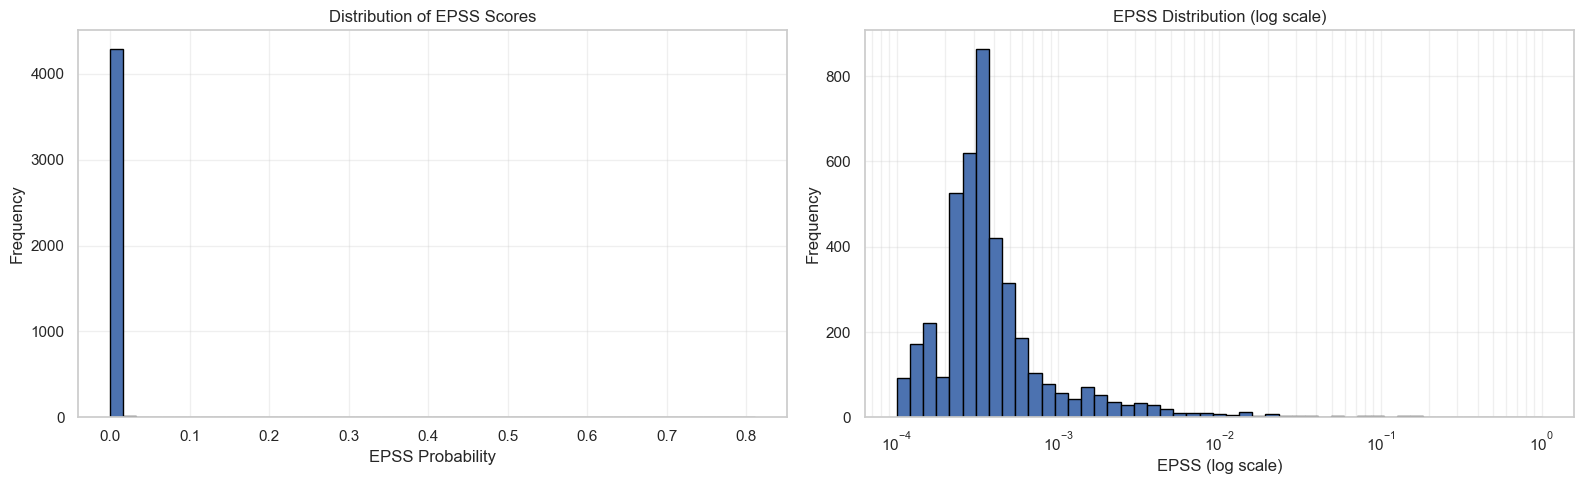

In [328]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  # 1 riga, 2 colonne

# --- Grafico lineare ---
ax1.hist(epss, bins=50, edgecolor='black')
ax1.set_title("Distribution of EPSS Scores")
ax1.set_xlabel("EPSS Probability")
ax1.set_ylabel("Frequency")
ax1.grid(alpha=0.3)

# --- Grafico logaritmico ---
ax2.hist(epss, bins=np.logspace(-4, 0, 50), edgecolor='black')
ax2.set_xscale('log')
ax2.set_title("EPSS Distribution (log scale)")
ax2.set_xlabel("EPSS (log scale)")
ax2.set_ylabel("Frequency")
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


### Scatter Plot of CVSS vs EPSS

A scatter plot was created to compare the CVSS base scores with the corresponding EPSS probabilities.  

The majority of points are clustered near an EPSS probability of **0**, reflecting that most vulnerabilities in the dataset have a very low predicted likelihood of exploitation. Despite this, CVSS base scores are spread across the full range from low to high severity.  

The trendline shows a slight positive slope, indicating a weak correlation between CVSS and EPSS: vulnerabilities with higher CVSS scores tend to have slightly higher EPSS probabilities on average, but the relationship is not strong. Overall, the plot highlights that **CVSS severity does not directly predict exploitability**, and most vulnerabilities, even those with high CVSS scores, have minimal predicted risk of exploitation according to EPSS.

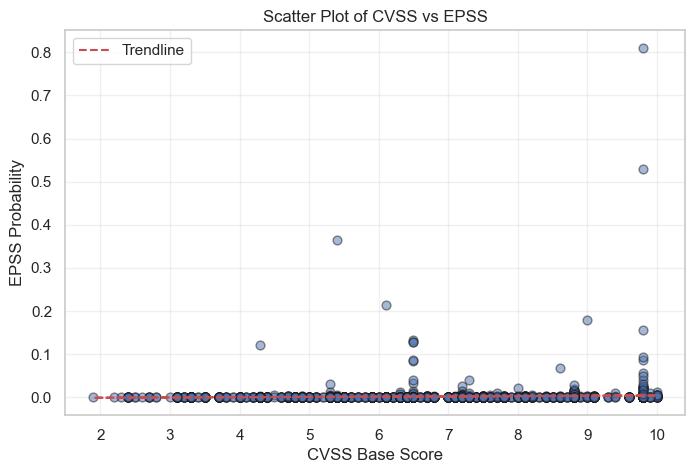

In [329]:
# 2️⃣ Filtra solo righe con CVSS e EPSS validi
df_clean = df.dropna(subset=["cvss_baseScore", "epss_current"]).copy()
df_clean["cvss_baseScore"] = df_clean["cvss_baseScore"].astype(float)
df_clean["epss_current"] = df_clean["epss_current"].astype(float)

# 3️⃣ Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(df_clean["cvss_baseScore"], df_clean["epss_current"], alpha=0.5, edgecolors='k', s=40)
plt.xlabel("CVSS Base Score")
plt.ylabel("EPSS Probability")
plt.title("Scatter Plot of CVSS vs EPSS")
plt.grid(alpha=0.3)

# 4️⃣ (Opzionale) aggiungere trendline
z = np.polyfit(df_clean["cvss_baseScore"], df_clean["epss_current"], 1)
p = np.poly1d(z)
plt.plot(df_clean["cvss_baseScore"], p(df_clean["cvss_baseScore"]), "r--", label="Trendline")
plt.legend()

plt.show()

# Extra

### Percentage of vulnerabilities in CISA KEV

In [330]:
print(
    f"Percentage of vulnerabilities in CISA KEV: {df["cve.cisaVulnerabilityName"].notna().sum() / len(df) * 100:.2f}%")


Percentage of vulnerabilities in CISA KEV: 0.21%


### Top Vendors by Number of Vulnerabilities

The top vulnerable CPEs are dominated by **Google Android**, **Microsoft Windows**, and **Apple macOS**. While most entries are operating systems, some critical applications like **Foxit PDF Editor** and **GitLab** also appear, highlighting the need to prioritize patching both OS and key software.


In [331]:
print("Most vulnerable vendors: \n\n",
      df["vulnerable_cpes"].explode().value_counts().head(20))

Most vulnerable vendors: 

 vulnerable_cpes
cpe:2.3:o:google:android:14.0:*:*:*:*:*:*:*                     110
cpe:2.3:o:apple:macos:*:*:*:*:*:*:*:*                           109
cpe:2.3:o:google:android:15.0:*:*:*:*:*:*:*                     108
cpe:2.3:o:google:android:13.0:*:*:*:*:*:*:*                      99
cpe:2.3:o:microsoft:windows_server_2025:*:*:*:*:*:*:*:*          59
cpe:2.3:o:microsoft:windows_server_2022_23h2:*:*:*:*:*:*:*:*     57
cpe:2.3:o:microsoft:windows_server_2022:*:*:*:*:*:*:*:*          55
cpe:2.3:o:google:android:16.0:*:*:*:*:*:*:*                      54
cpe:2.3:o:microsoft:windows_server_2019:*:*:*:*:*:*:*:*          50
cpe:2.3:o:microsoft:windows_11_24h2:*:*:*:*:*:*:*:*              49
cpe:2.3:o:microsoft:windows_11_23h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_11_22h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_server_2016:*:*:*:*:*:*:*:*          44
cpe:2.3:o:microsoft:windows_10_1809:*:*:*:*:*:*:x64:*            40
cpe:

In [332]:
# Creiamo il grafico direttamente con value_counts() e head(20)
top_20_cpe = df["vulnerable_cpes"].explode().value_counts().head(20).reset_index()
top_20_cpe.columns = ['CPE', 'Count']

# Grafico a barre orizzontale
fig = px.bar(
    top_20_cpe[::-1],  # inverti per ordinare dal più alto in basso
    x='Count',
    y='CPE',
    orientation='h',
    title='Top 20 Most Vulnerable CPEs',
    text='Count'
)

fig.update_layout(
    yaxis_title='CPE',
    xaxis_title='Number of Vulnerabilities',
    template='plotly_white'
)

fig.show()


### Top 20 Most Frequent CWEs

The analysis of the CWE field reveals that **CWE-79 (Cross-site Scripting)** is the most frequent, with 715 occurrences, followed by **CWE-89 (SQL Injection)** with 432 occurrences and **CWE-74 (Injection)** with 294.  

Other frequent CWEs include **CWE-862 (Missing Authorization), CWE-352 (Cross-Site Request Forgery), and CWE-94 (Code Injection)**, indicating that injection and authorization issues are prevalent in the dataset.  

Overall, the top 20 CWEs represent the most common types of vulnerabilities, highlighting areas where security efforts should be focused.


In [333]:
print(df["cwe_list"].explode().value_counts().head(20))

cwe_list
CWE-79     715
CWE-89     432
CWE-74     294
CWE-862    203
CWE-352    160
CWE-94     134
CWE-284    119
CWE-77      99
CWE-78      89
CWE-434     86
CWE-918     74
CWE-22      73
CWE-125     67
CWE-20      67
CWE-200     66
CWE-787     63
CWE-502     62
CWE-266     62
CWE-119     61
CWE-285     57
Name: count, dtype: int64


# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


Filtering the CVEs with low EPSS (<1%)

In [334]:
df = df[df["epss_current"] < 0.01]


### EPSS–CVSS Ranking Code Summary

The code identifies and ranks high-risk vulnerabilities according to these CVSS exploitability metrics (that I chosen):

1. Computes the change in EPSS percentile over time (`percentile_diff`) to highlight vulnerabilities with increasing likelihood of exploitation.
2. Filters CVEs based on the following criteria ():  
   - `cvss_attackComplexity` is **LOW** or **MEDIUM**  
   - `cvss_attackVector` is **NETWORK** (It is much easier to consider a vulnerability that can be exploited via the network as important)
   - `cvss_privilegesRequired` is **NONE** (if it does not require privileges, it means that it is more dangerous and easier to exploit)
   - `cvss_userInteraction` is **NONE** (if it does not require user interaction, it means that there is no need for human intervention by staff or customers)  
   These conditions select vulnerabilities that are remotely exploitable without privileges or user interaction.
3. Sorts the filtered vulnerabilities by `cvss_baseScore` to prioritize the most severe.
4. Extracts the top 10 CVEs (`top10_cves`) as the final high-risk subset.


In [335]:
df['percentile_diff'] = df['percentile_current'] - df['percentile_old']
df.sort_values("percentile_diff", axis=0, ascending=False, inplace=True)

# Filter by updated criteria
df = df[
    (df["cvss_attackComplexity"].isin(["LOW", "MEDIUM"])) &  # LOW or MEDIUM
    (df["cvss_attackVector"] == "NETWORK") &                 # Network-based
    (df["cvss_privilegesRequired"] == "NONE") &              # No privileges
    (df["cvss_userInteraction"] == "NONE")                   # No user interaction
]

df = df.sort_values(by="cvss_baseScore", ascending=False)

top10_cves = df.iloc[:10]["cve.id"]
top10_cves



1720    CVE-2025-10264
2372    CVE-2025-41243
676     CVE-2025-55241
672     CVE-2025-54914
3439    CVE-2025-59528
1116    CVE-2025-42944
2344    CVE-2025-55113
1355    CVE-2025-55729
1356    CVE-2025-55730
2628    CVE-2025-59340
Name: cve.id, dtype: object

### Clean-up of merged EPSS data
This code keeps only the relevant columns after merging current and old EPSS scores, standardizing the CVE, EPS, and percentile columns, and dropping temporary or duplicate columns.


In [336]:
to_drop = ['cve_x',
           'cve_y',
           'epss_current',
           'percentile_current',
           'epss_old',
           'percentile_old',
           'percentile_diff']

df['cve'] = df['cve_x']
df['epss'] = df['epss_current']
df['percentile'] = df['percentile_current']
df.drop(columns=to_drop, inplace=True)


### My selection of CVEs

In [337]:
nickname = 'NoTimeToDie'


# TODO: put your selected IDs here
selected = top10_cves.tolist()
print(selected)
# selected = ['CVE-2025-41243', 'CVE-2025-59528', 'CVE-2025-59834', 'CVE-2025-10412', 'CVE-2025-9054', 'CVE-2025-9321', 'CVE-2025-59360', 'CVE-2025-59361', 'CVE-2025-59359', 'CVE-2025-57141']         

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            

['CVE-2025-10264', 'CVE-2025-41243', 'CVE-2025-55241', 'CVE-2025-54914', 'CVE-2025-59528', 'CVE-2025-42944', 'CVE-2025-55113', 'CVE-2025-55729', 'CVE-2025-55730', 'CVE-2025-59340']
